In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import print_function
from orphics import maps,cosmology,io,lensing
from enlib import enmap,bench,fft
import numpy as np
from szar import counts
from scipy.interpolate import interp1d

/home/msyriac/repos/orphics/orphics/tools/io.py:3: UserWarning: WARNING: This module is deprecated. Most of its contents have moved to orphics.io. If you do not find the function you require there, please raise an issue.
  warnings.warn("WARNING: This module is deprecated. Most of its contents have moved to orphics.io. If you do not find the function you require there, please raise an issue.")
/home/msyriac/repos/orphics/orphics/tools/stats.py:3: UserWarning: WARNING: This module is deprecated. Most of its contents have moved to orphics.stats. If you do not find the function you require there, please raise an issue.
  warnings.warn("WARNING: This module is deprecated. Most of its contents have moved to orphics.stats. If you do not find the function you require there, please raise an issue.")


In [17]:
Nsims = 1000

Nlkk = 2.e-11
shape,wcs = maps.rect_geometry(width_arcmin=100.,px_res_arcmin=0.5,pol=False)
modlmap = enmap.modlmap(shape,wcs)
modrmap = enmap.modrmap(shape,wcs)
lmax = modlmap.max()
ells = np.arange(0,lmax,1)
ps = np.array([Nlkk]*ells.size).reshape((1,1,ells.size))
nkk2d = interp1d(ells,ps[0,0],bounds_error=False,fill_value=False)(modlmap)
lowpass = 6000
ps[0,0,ells>lowpass] = 0
ngen = maps.MapGen(shape,wcs,ps)

normfact = np.sqrt(np.prod(enmap.pixsize(shape,wcs)))
area = enmap.area(shape,wcs)
normfact2 = area / (np.prod(shape))**2

cc = counts.ClusterCosmology(skipCls=True)

taper,w2 = maps.get_taper(shape)

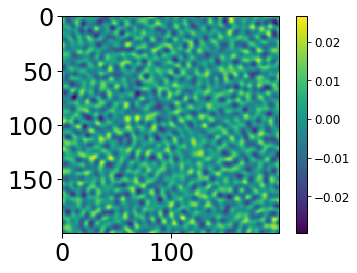

In [6]:
noise = ngen.get_map()
io.plot_img(noise)

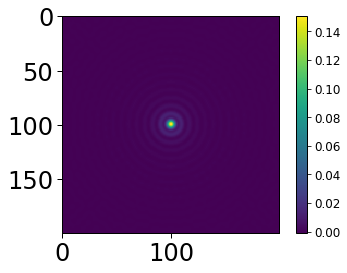

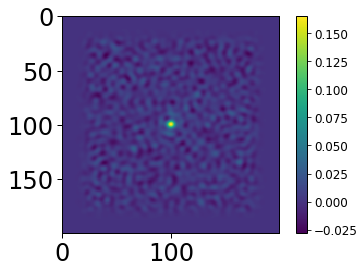

In [19]:
kmask = maps.mask_kspace(shape,wcs,lmin=0,lmax=lowpass)
kappa = maps.filter_map(lensing.nfw_kappa(2e14,modrmap,cc),kmask)
kappa0 = maps.filter_map(lensing.nfw_kappa(2e14,modrmap,cc),kmask)#,concentration=1.0),kmask)

io.plot_img(kappa)
io.plot_img((kappa+noise)*taper**2.)

In [20]:
mf = maps.MatchedFilter(shape,wcs,template=kappa0,noise_power=nkk2d)


phi0s = []
phi_var_tot_inv = 0.
for i in range(Nsims):
    noise = ngen.get_map()
    sim = (kappa.copy()+noise)*taper**2.
    
    ksim = enmap.fft(sim,normalize=False)
    
    #phi_un = np.nansum(ktemp.conj()*ksim*normfact2/nkk2d).real 
    #phi_var = 1./np.nansum(ktemp.conj()*ktemp*normfact2/nkk2d).real 
    
    #phi0 = phi_un*phi_var
    
    phi0, phi_var = mf.apply(kmap=ksim)
    phi_var_tot_inv += 1./phi_var
    phi0s.append(phi0)
    
    
phi_mean = np.mean(phi0s)
phi_dvar = np.var(phi0s)
print(phi_dvar,phi_var)
phi_err = np.sqrt(phi_var)
print(phi_mean,phi_err,phi_mean/phi_err,phi_mean/np.sqrt(phi_dvar))
phi_var_tot = 1./phi_var_tot_inv
print(phi_mean/phi_err*np.sqrt(Nsims),phi_mean/np.sqrt(phi_dvar/Nsims),phi_mean/np.sqrt(phi_var_tot))


0.00143820016199 0.00161672093571
0.992870854694 0.0402084684577 24.6930781693 26.1808110103
780.863694556 827.90993783 780.863694556


In [21]:
bin_edges = np.linspace(0.7,1.3,500)
hist,_ = np.histogram(phi0s,bins=bin_edges,density=True)
cents = (bin_edges[1:]+bin_edges[:-1])/2.

1.0 1.0


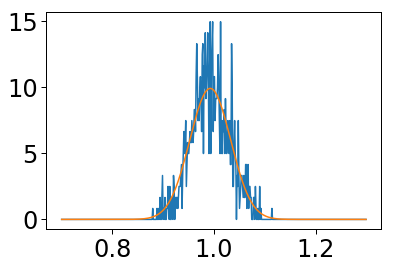

In [22]:
gauss = np.exp(-(cents-phi_mean)**2./2./phi_err**2.)/np.sqrt(2.*np.pi*phi_err**2.)
#lnlike = np.log(hist)
#lnlike -= lnlike.max()
#like = np.exp(hist)
like = hist
print(np.trapz(hist,cents),np.trapz(gauss,cents))
#print(like)
#print(like.sum())
#like /= like.sum()
#gauss /= gauss.sum()

pl = io.Plotter()
pl.add(cents,like)#/hist.max())
pl.add(cents,gauss)
pl.done()